In [1]:
# 使用pandas读取数据
import pandas as pd


# 关闭不必要的warning
pd.options.mode.chained_assignment = None
data_path = "./data/adult.data"
raw_data = pd.read_csv(data_path)
## 选取需要使用的列
cols = ["age", "education_num", "capital_gain", "capital_loss", "hours_per_week", "label"]
data = raw_data[cols]

In [2]:
# 将label转换为可以运算的变量
data.loc[:, "label_code"] = pd.Categorical(data.label).codes
data.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,label,label_code
0,39,13,2174,0,40,<=50K,0
1,50,13,0,0,13,<=50K,0
2,38,9,0,0,40,<=50K,0
3,53,7,0,0,40,<=50K,0
4,28,13,0,0,40,<=50K,0


In [3]:
# 将数据分为训练集和测试集
from sklearn.model_selection import train_test_split


train_set, test_set = train_test_split(data, test_size=0.2, random_state=2310)

In [4]:
# 训练模型
from sklearn.linear_model import LogisticRegression


features = ["age", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
label = "label_code"
model = LogisticRegression()
model.fit(train_set[features], train_set[label])

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [5]:
# 得到预测结果
test_set.loc[:, "prob"] = model.predict_proba(test_set[features])[:, 1]
alpha = 0.5
test_set.loc[:, "pred"] = test_set.apply(lambda x: 1 if x["prob"] > alpha else 0, axis=1)

In [6]:
# 计算查准查全率以及f1
import numpy as np


bins = np.array([0, 0.5, 1])
tn, fp, fn, tp = np.histogram2d(test_set[label], test_set["pred"], bins=bins)[0].flatten()
precision = tp / (tp + fp)  # 0.728
recall = tp / (tp + fn)  # 0.333
f1 = 2 * precision * recall / (precision + recall)  # 0.457
print("查准率: %.3f, 查全率: %.3f, f1: %.3f" % (precision, recall, f1))

查准率: 0.728, 查全率: 0.333, f1: 0.457


In [7]:
from sklearn.metrics import precision_recall_fscore_support


print(precision_recall_fscore_support(test_set[label], test_set["pred"]))

(array([0.81854282, 0.72815534]), array([0.96029978, 0.33312183]), array([0.88377295, 0.45711798]), array([4937, 1576]))


In [7]:
# 计算AUC
from sklearn import metrics


fpr, tpr, _ = metrics.roc_curve(test_set[label], test_set["prob"])
# 得到AUC
auc = metrics.auc(fpr, tpr)
print(auc)

0.8301193386929114


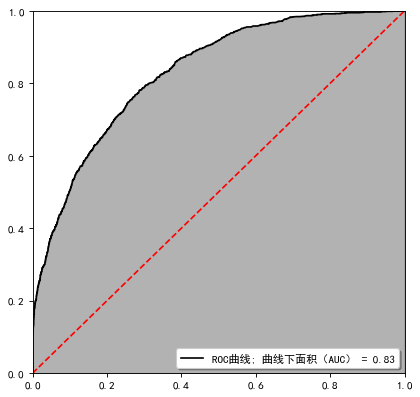

In [9]:
# ROC曲线
import matplotlib.pyplot as plt


plt.rcParams["font.sans-serif"] = ["SimHei"]
fig = plt.figure(figsize=(6, 6), dpi=80)
# 在图形框里只画一幅图
ax = fig.add_subplot(1, 1, 1)
ax.plot(fpr, tpr, "k",
        label="%s; %s = %0.2f" % ("ROC曲线", "曲线下面积（AUC）", auc))
ax.fill_between(fpr, tpr, color="grey", alpha=0.6)
ax.plot([0, 1], [0, 1], "r--")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
legend = plt.legend(shadow=True)
plt.show()